# Analysis of Protein Structure Prediction Results

## Colab Setup

1. Check the runtime instance
2. Choose whether to use Google Drive (persistence) or temp `/content`
3. Install required Python packages
4. Get course files/data into the runtime
5. Mount Google Drive for persistent storage


## 1) Check the runtime


In [3]:
import sys, platform, os, textwrap
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Working dir:", os.getcwd())


Python: 3.12.12
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Working dir: /content


In [4]:
!arch

x86_64


## 2) Choose whether to use Google Drive (persistence)

- If you want your edits to persist across sessions, use **Drive**.
- If you're just running a quick exercise, you can skip Drive and use the temporary Colab filesystem (`/content`).


In [38]:
USE_DRIVE = True  # set False if you want to skip Drive mounting

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted at /content/drive")
else:
    print("Skipping Drive mount.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted at /content/drive


In [39]:
import os
from pathlib import Path

# Change this folder name once; everything else uses it.
COURSE_DIR_NAME = "structbio_course"  # you can rename for your course

if "drive" in str(Path("/content/drive")) and os.path.exists("/content/drive") and USE_DRIVE:
    ROOT = Path("/content/drive/MyDrive") / COURSE_DIR_NAME
else:
    ROOT = Path("/content") / COURSE_DIR_NAME

ROOT.mkdir(parents=True, exist_ok=True)

DATA_DIR = ROOT / "data"
(DATA_DIR).mkdir(exist_ok=True)

OUTPUTS_DIR = ROOT / "outputs"
(OUTPUTS_DIR).mkdir(exist_ok=True)

print("ROOT:", ROOT)
print("data:", DATA_DIR)
print("outputs:", OUTPUTS_DIR)


ROOT: /content/drive/MyDrive/structbio_course
data: /content/drive/MyDrive/structbio_course/data
outputs: /content/drive/MyDrive/structbio_course/outputs


## 2) Get a copy of the AF2, AF3 and ESMFold results that we will analyze

... and unzip the archive


In [47]:
import os, pathlib, urllib.request

RAW_URL = "https://raw.githubusercontent.com/vvoelz/chem5412-spring2026/main/data/assignment01.zip"
zip_path = pathlib.Path(DATA_DIR) / "assignment01.zip"

urllib.request.urlretrieve(RAW_URL, zip_path)
print("Saved to:", zip_path)

!unzip {zip_path}
!cp assignment01 {DATA_DIR}

print(f'Unzipped folder `assignment01` moved to {DATA_DIR}')

Saved to: /content/drive/MyDrive/structbio_course/data/assignment01.zip
Archive:  /content/drive/MyDrive/structbio_course/data/assignment01.zip
replace assignment01/ESMFold_demo/ESMFold.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: assignment01/ESMFold_demo/ESMFold.ipynb  
  inflating: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.pdb  
  inflating: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.pae.txt  
  inflating: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.png  
 extracting: assignment01/ESMFold_demo/README.md  
 extracting: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382.zip  
 extracting: assignment01/AF3_demo/README.md  
  inflating: assignment01/AF3_demo/fold_vav_2026_01_31_15_42/fold_vav_2026_01_31_15_42_summary_confidences_1.json  
  inflating: assignment01/AF3_demo/fold_vav_2026_01_31_15_42/msas/fold_vav_2026_01_31_15_42_paired_msa_chains_a.a3m  
  inflating: assignment01/AF3_demo/fold_vav_

## 3) Get the experimental PDB file

We'll need the following packages:

In [26]:
!pip -q install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.7 MB/s eta 0:00:00


In [48]:
from Bio.PDB import PDBParser, PDBIO, Select
import requests
from pathlib import Path

# ---- paths ----
WORK_DIR = pathlib.Path(DATA_DIR) / "assignment01"
# This should exist if cells above are successful

pdb_id = "7D2O"
full_pdb = WORK_DIR / f"{pdb_id}_full.pdb"
model1_pdb = WORK_DIR / f"{pdb_id}_model1.pdb"

# ---- download ----
url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
resp = requests.get(url, timeout=30)
resp.raise_for_status()
full_pdb.write_text(resp.text)

print("Downloaded:", full_pdb)

# ---- select only MODEL 1 ----
class ModelSelect(Select):
    def accept_model(self, model):
        return model.id == 0   # MODEL 1 → id == 0 in Biopython

parser = PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, str(full_pdb))

io = PDBIO()
io.set_structure(structure)
io.save(str(model1_pdb), select=ModelSelect())

print("Saved MODEL 1 only to:", model1_pdb)


Downloaded: /content/drive/MyDrive/structbio_course/data/assignment01/7D2O_full.pdb
Saved MODEL 1 only to: /content/drive/MyDrive/structbio_course/data/assignment01/7D2O_model1.pdb


In [51]:
!head -20 {model1_pdb}

MODEL      1
ATOM      1  N   LYS A   1      -3.395   9.371  24.583  1.00  0.00          N  
ATOM      2  CA  LYS A   1      -2.630   9.369  23.342  1.00  0.00          C  
ATOM      3  C   LYS A   1      -1.521   8.323  23.388  1.00  0.00          C  
ATOM      4  O   LYS A   1      -1.115   7.860  24.455  1.00  0.00          O  
ATOM      5  CB  LYS A   1      -2.029  10.754  23.088  1.00  0.00          C  
ATOM      6  CG  LYS A   1      -2.892  11.638  22.204  1.00  0.00          C  
ATOM      7  CD  LYS A   1      -3.009  13.045  22.767  1.00  0.00          C  
ATOM      8  CE  LYS A   1      -4.411  13.322  23.288  1.00  0.00          C  
ATOM      9  NZ  LYS A   1      -4.390  14.151  24.525  1.00  0.00          N  
ATOM     10  H   LYS A   1      -2.918   9.371  25.439  1.00  0.00          H  
ATOM     11  HA  LYS A   1      -3.305   9.125  22.536  1.00  0.00          H  
ATOM     12  HB2 LYS A   1      -1.891  11.253  24.035  1.00  0.00          H  
ATOM     13  HB3 LYS A   1 

## 4) Compute per-residue LDDT scores of predictd structures, using the experimental structure as the reference

In [52]:
!pip -q install biotite

import numpy as np
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.sequence as seq
import biotite.sequence.align as align

def read_pdb_as_atoms(pdb_path, model=1):
    """
    Read a PDB file into a Biotite AtomArray.
    model=1 means 'MODEL 1' (Biotite uses 1-based model index here).
    """
    f = pdb.PDBFile.read(pdb_path)
    atoms = f.get_structure(model=model)
    # Keep amino acids only (drop waters/ions/ligands)
    atoms = atoms[struc.filter_amino_acids(atoms)]
    return atoms

ref_path   =  model1_pdb     # <-- your experimental PDB
model_path = WORK_DIR / f"AF2_demo/prediction_1/best_model.pdb"   # <-- your predicted PDB

reference = read_pdb_as_atoms(ref_path, model=1)
model     = read_pdb_as_atoms(model_path, model=1)

# --- Build sequences from structures ---
ref_seq   = struc.to_sequence(reference)[0][0]
model_seq = struc.to_sequence(model)[0][0]

# --- Align sequences to find overlap (robust to differing residue numbering) ---
# Use an identity matrix to avoid "creative" substitutions; good for same protein / close homologs
identity = align.SubstitutionMatrix(
    seq.ProteinSequence.alphabet,
    seq.ProteinSequence.alphabet,
    np.eye(len(seq.ProteinSequence.alphabet), dtype=int),
)

aln = align.align_optimal(
    ref_seq,
    model_seq,
    identity,
    gap_penalty=-1,
    terminal_penalty=False,
    max_number=1,
)[0]

# Keep only aligned columns with residue-residue correspondence (drop gaps)
aln = aln[(aln.trace != -1).all(axis=1)]

# Map alignment columns -> residue indices, then -> atom masks
ref_starts   = struc.get_residue_starts(reference)
model_starts = struc.get_residue_starts(model)

ref_mask = struc.get_residue_masks(reference, ref_starts)[aln.trace[:, 0]].any(axis=0)
mod_mask = struc.get_residue_masks(model,     model_starts)[aln.trace[:, 1]].any(axis=0)

reference_olap = reference[ref_mask]
model_olap     = model[mod_mask]

# For lDDT, it's common to use CA atoms (and it matches the common pLDDT interpretation)
ref_ca = reference_olap[reference_olap.atom_name == "CA"]
mod_ca = model_olap[model_olap.atom_name == "CA"]

# --- Per-residue lDDT ---
lddt_per_res = struc.lddt(ref_ca, mod_ca, aggregation="residue")
res_ids = np.unique(mod_ca.res_id)

print("Per-residue lDDT (first 10):")
for rid, val in list(zip(res_ids, lddt_per_res))[:10]:
    print(rid, f"{val:.3f}")

print("Global lDDT (mean over residues):", float(np.nanmean(lddt_per_res)))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.6 MB/s eta 0:00:00
Per-residue lDDT (first 10):
1 0.221
2 0.190
3 0.289
4 0.350
5 0.298
6 0.220
7 0.165
8 0.207
9 0.195
10 0.228
Global lDDT (mean over residues): 0.49799206147925734


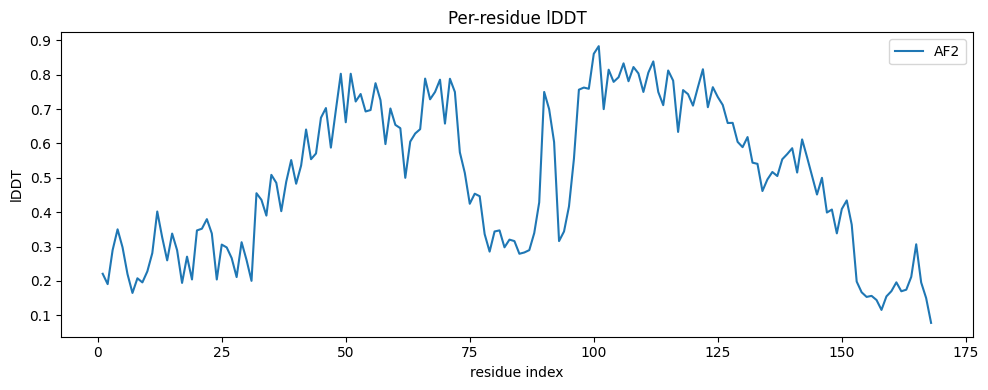

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10.,4.))
plt.plot(res_ids, lddt_per_res, label='AF2')
plt.title("Per-residue lDDT")
plt.xlabel("residue index")
plt.ylabel("lDDT")
plt.legend(loc='best')
plt.tight_layout()

## 4) Quick structure visualization check

We’ll use simple viewers in Colab:
- `py3Dmol` (browser-based, easy)
- (optional) `nglview` (more featureful, sometimes finicky)

Below: fetch a PDB and render it.


In [ ]:
import requests, textwrap
import py3Dmol

PDB_ID = "1CRN"  # crambin (small test structure)
url = f"https://files.rcsb.org/download/{PDB_ID}.pdb"
pdb_txt = requests.get(url).text

view = py3Dmol.view(width=600, height=450)
view.addModel(pdb_txt, "pdb")
# view.setStyle({"cartoon": {}})
view.setStyle({"stick": {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 5) Saving your work and submitting

**Saving**
- If you opened from a link, click: `File → Save a copy in Drive` (recommended)
- Or download: `File → Download → .ipynb`

**Submitting**
- You will submit either:
  - a `.ipynb` file (preferred), or
  - a PDF export of the notebook, depending on the assignment.

**If you get stuck**
- Restart runtime: `Runtime → Restart runtime`
- Re-run the install cell(s)
- Post the error message + what cell it came from


## Next steps
Open the first exercise notebook from the course site and repeat the same workflow:
1. Install packages (if needed)
2. Pull data from the repo (or download as instructed)
3. Run analysis
4. Save a copy to Drive


In [ ]:
import os, sys, glob
import json

import numpy as np
from matplotlib import pyplot as plt

VERBOSE = True


### Load in the predicted pLDDT values from AF2

AF2_dir = '../AF2_predictions'
json_files = glob.glob( os.path.join(AF2_dir,'af168_scores_rank_00?_alphafold2_ptm_model_?_seed_000.json'))
json_files.sort()   # sort in place

n = len(json_files)
af2_labels = [f'AF2 model{i}' for i in range(n)]
print('json_files', json_files)

all_data  = []

# Open and read the JSON file
for json_file in json_files:
    with open(json_file, 'r') as file:
        data = json.load(file)

    if VERBOSE:
        print(data["plddt"])
    all_data.append( data["plddt"] )   # these are per-residue c

all_data = np.array(all_data).transpose()
print('all_data.shape', all_data.shape)

### Alternatively, we could read in the pLDDT values from the `best_model.pdb' B-factors
if (0):
    # NOTE: these pLDDT values are per-atom, not per-residue, so we need to have a mapping from
    #       atomindex to residue index
    import subprocess
    cmd = f'cat {os.path.join(AF2_dir,"best_model.pdb")} | grep ATOM'
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    print('result', result)

    lines = result.stdout.split('\n')
    chain_of_atomnum, resnum_of_atomnum = {}, {}
    atomnums, chains, resnums = [], [], []
    for line in lines:
        try:
            fields = line.split()   # ATOM   3244  CD2 HIS B 209
            atomnum, chain, resnum = int(fields[1]), fields[4], int(fields[5])
            chain_of_atomnum[atomnum] = chain
            resnum_of_atomnum[atomnum] = resnum
            atomnums.append(atomnum)
            chains.append(chain)
            resnums.append(resnum)
        except:
            pass

### Load the ACTUAL lddt from a csv  (obtained from https://swissmodel.expasy.org/assess )
import pandas as pd
actual_lddt_csv = 'SuORj1_01_lddt.csv'
actual = pd.read_csv(actual_lddt_csv)
print(actual["lddt"])
print(actual["mdl_res_no"])


plt.figure(figsize=(10.,4.))
plt.plot(actual["mdl_res_no"], all_data/100.0, '.', label=af2_labels, ms=1)    # divide by 100 to convert from percent
plt.plot(actual['mdl_res_no'], actual["lddt"], label='actual LDDT')
plt.xlabel('model residue number')
plt.ylabel('pLDDT / LDDT')
plt.legend(loc='best')
plt.tight_layout()
# plt.show()

outpng = 'AF2_monomer_pLDDT_vs_actual.png'
plt.savefig(outpng)
print('Wrote:', outpng)
